In [ ]:
!pip install --upgrade scikit-learn
# !pip install transformers[torch]
!pip install accelerate -U

from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from typing import List, Dict, Tuple
from transformers.tokenization_utils_base import BatchEncoding
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

!pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Research/Datasets/Indonesia-hatespeech-preprocessed/data_preprocessed.csv', header = 0)
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11103 entries, 0 to 11102
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   hs_class  11103 non-null  object
 1   text      11068 non-null  object
dtypes: object(2)
memory usage: 173.6+ KB


,hs_class,text
1208,positive,lost respect sekian kali agency bangga a is ba...
3758,positive,satria udik
8796,negative,NaN
5143,positive,kebut infrastruktur biar anggap presiden bangu...
2292,positive,2 analisa kait 1 susup komunis 2 antek jendera...


In [ ]:
from wordcloud import WordCloud , STOPWORDS
cloud1 = WordCloud(stopwords =STOPWORDS, background_color='white',min_word_length=2,random_state= 53).generate(str(df[df.hs_class=='negative']['text'].values))
cloud2 = WordCloud(stopwords =STOPWORDS, background_color='white',min_word_length=2,random_state= 53).generate(str(df[df.hs_class=='positive']['text'].values))

In [ ]:
cloud1.words_
for key in cloud1.words_.keys():
    if cloud2.words_.get(key,False):
        if cloud2.words_.get(key,None)> 0.4 and cloud1.words_.get(key,None) > 0.4:
            print(f'{key:10} {round(cloud1.words_[key],2):10}{round(cloud2.words_[key],2):10}')

ya                1.0       1.0
lihat             0.5       0.5


Text(0.5, 1.0, 'positive')

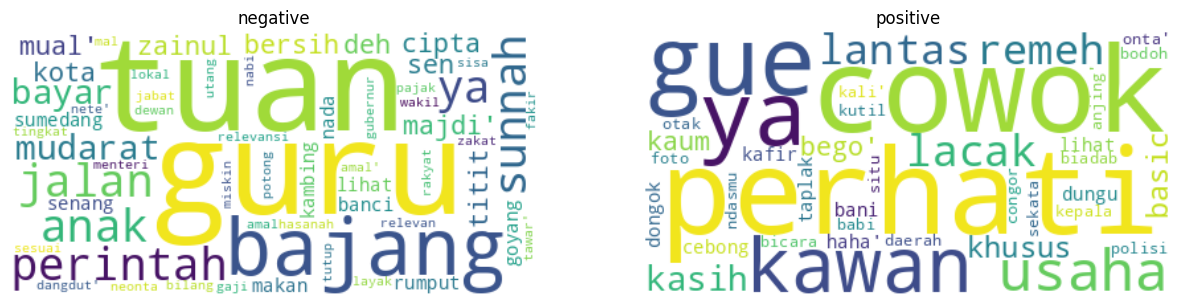

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.imshow(cloud1, interpolation = 'bilinear')
ax1.axis('off')
ax1.set_title("negative")

ax2.imshow(cloud2, interpolation = 'bilinear')
ax2.axis('off')
ax2.set_title("positive")

In [ ]:
# Step 1: Data Preprocessing
# Assuming df is your DataFrame containing 'hs_class' and 'text' columns
# Handle missing values
df.dropna(subset=['text'], inplace=True)

# Encode labels
label_mapping = {"positive": 1, "negative": 0}
df['label'] = df['hs_class'].map(label_mapping)

# Split into train and eval datasets
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize text
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
train_encodings = tokenizer(train_df["text"].tolist(), truncation=True, padding=True, return_tensors='pt', max_length=512)
eval_encodings = tokenizer(eval_df["text"].tolist(), truncation=True, padding=True, return_tensors='pt', max_length=512)

train_dataset = torch.utils.data.TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_df["label"].tolist()))
eval_dataset = torch.utils.data.TensorDataset(eval_encodings['input_ids'], eval_encodings['attention_mask'], torch.tensor(eval_df["label"].tolist()))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Step 2: Model Building
model = AutoModelForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", num_labels=2)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 3: Training
training_args = TrainingArguments(
    output_dir="./results",  # Output directory
    overwrite_output_dir=True,
    num_train_epochs=1,  # Total number of training epochs
    per_device_train_batch_size=8,  # Batch size per device during training
    per_device_eval_batch_size=8,  # Batch size for evaluation
    evaluation_strategy="epoch",  # Evaluation strategy to adopt during training
    logging_dir="./logs",  # Directory for storing logs
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

def custom_data_collator(features: List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    """
    Custom data collator for handling features as lists of tuples.
    Each tuple should contain 'input_ids', 'attention_mask', and 'label' tensors.
    """
    batch = {}
    batch['input_ids'] = torch.stack([feature[0] for feature in features])
    batch['attention_mask'] = torch.stack([feature[1] for feature in features])
    batch['labels'] = torch.tensor([feature[2] for feature in features])
    return batch

# Replace the default data collator with our custom data collator
trainer.data_collator = custom_data_collator


trainer.train()

Epoch,Training Loss,Validation Loss
1,0.417100,0.402455


TrainOutput(global_step=1107, training_loss=0.5150937219945396, metrics={'train_runtime': 205.8605, 'train_samples_per_second': 43.01, 'train_steps_per_second': 5.377, 'total_flos': 391297528198320.0, 'train_loss': 0.5150937219945396, 'epoch': 1.0})

In [ ]:
# Step 4: Evaluation
predictions = trainer.predict(eval_dataset)
y_true = eval_df["label"].tolist()
y_pred = predictions.predictions.argmax(-1)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
# loss = predictions.loss
conf_matrix = confusion_matrix(y_true, y_pred)

print("Evaluation Results:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# print("Loss:", loss)

Evaluation Results:
Accuracy: 0.8265582655826558
Precision: 0.8217734855136084
Recall: 0.8379588182632051
F1 Score: 0.8297872340425532


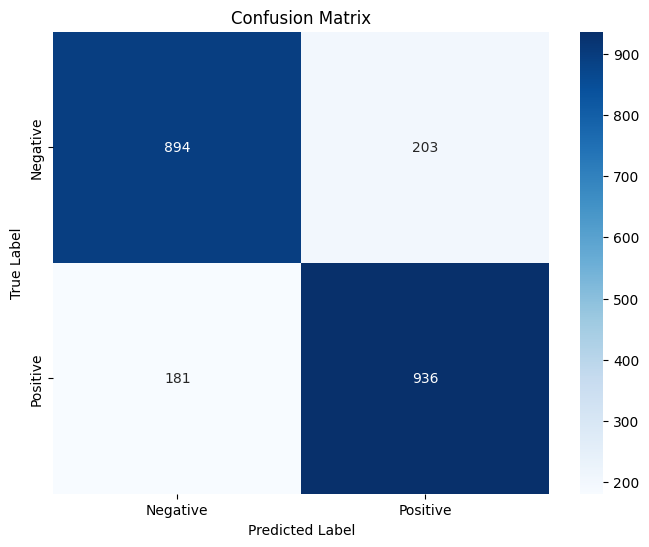

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ["Negative", "Positive"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()